## 1. Setup Environment & Install Dependencies

In [ ]:
# Install Ultralytics (YOLOv8 & YOLOv11)
!pip install ultralytics -q
!pip install opencv-python matplotlib seaborn pandas numpy scikit-learn -q

import ultralytics
ultralytics.checks()

In [ ]:
# Import libraries
import os
import cv2
import yaml
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from ultralytics import YOLO
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Check GPU availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
else:
    print("⚠️ No GPU detected. Training will use CPU (slower).")

## 2. Data Verification & Preprocessing Configuration

In [ ]:
# Define paths
data_yaml = r'/kaggle/input/oil-dataset/data.yaml'
dataset_path = Path(r'/kaggle/input/oil-dataset')

# Load and verify data.yaml
with open(data_yaml, 'r') as f:
    data_config = yaml.safe_load(f)

print("="*70)
print("DATASET CONFIGURATION")
print("="*70)
print(f"Dataset path: {data_config['path']}")
print(f"Train images: {data_config['train']}")
print(f"Val images: {data_config['val']}")
print(f"Test images: {data_config['test']}")
print(f"Number of classes: {data_config['nc']}")
print(f"Class names: {data_config['names']}")

# Count files in each split
for split in ['train', 'val', 'test']:
    img_dir = dataset_path / split / 'images'
    lbl_dir = dataset_path / split / 'labels'
    
    num_imgs = len(list(img_dir.glob('*')))
    num_lbls = len(list(lbl_dir.glob('*.txt')))
    
    # Count empty labels (background images)
    empty_lbls = 0
    for lbl_file in lbl_dir.glob('*.txt'):
        if lbl_file.stat().st_size == 0:
            empty_lbls += 1
    
    print(f"\n{split.upper()}: {num_imgs} images, {num_lbls} labels")
    print(f"  - With objects: {num_lbls - empty_lbls}")
    print(f"  - Background: {empty_lbls} ({empty_lbls/num_lbls*100:.1f}%)")

print("="*70)

## 3. Training Configuration

In [ ]:
# Training hyperparameters
EPOCHS = 100
BATCH_SIZE = 32  # Adjust based on GPU memory (8 for low VRAM, 32 for high VRAM)
IMG_SIZE = 640
PATIENCE = 10  # Early stopping patience
WORKERS = 8  # Data loading workers

# Augmentation parameters (optimized for dipstick detection)
augmentation_params = {
    'hsv_h': 0.015,  # Hue augmentation
    'hsv_s': 0.7,    # Saturation augmentation
    'hsv_v': 0.4,    # Value augmentation
    'degrees': 10.0,  # Rotation degrees
    'translate': 0.1, # Translation
    'scale': 0.5,     # Scaling factor
    'shear': 0.0,     # Shear
    'perspective': 0.0,  # Perspective
    'flipud': 0.5,    # Vertical flip probability
    'fliplr': 0.5,    # Horizontal flip probability
    'mosaic': 1.0,    # Mosaic augmentation probability
    'mixup': 0.1,     # Mixup augmentation probability
    'copy_paste': 0.1 # Copy-paste augmentation
}

print("Training Configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Early Stopping Patience: {PATIENCE}")
print(f"  Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

## 4. Training YOLOv11-seg (Latest Architecture)

In [ ]:
# Initialize YOLOv11-seg model with pre-trained weights
print("="*70)
print("TRAINING YOLOv11-SEGMENTATION")
print("="*70)

model_v11 = YOLO('yolo11n-seg.pt')  # YOLOv11 segmentation model

# Train the model
results_v11 = model_v11.train(
    data='/kaggle/input/oil-dataset/data.yaml',
    epochs=EPOCHS,
    batch=BATCH_SIZE,
    imgsz=IMG_SIZE,
    patience=PATIENCE,
    workers=WORKERS,
    device=0 if torch.cuda.is_available() else 'cpu',
    project='runs/segment',
    name='yolo11n-dipstick',
    exist_ok=True,
    pretrained=True,
    optimizer='AdamW',
    verbose=True,
    seed=42,
    deterministic=True,
    plots=True,
    amp=True,
    # Augmentation parameters
    **augmentation_params
)

print("\n✓ YOLOv11-seg training complete!")
print(f"Best model saved at: {model_v11.trainer.best}")
print(f"Metrics saved at: runs/segment/yolo11n-dipstick/")

## 5. Model Evaluation - YOLOv11-seg

In [ ]:
# Load best YOLOv11 model
best_model_v11 = YOLO('/kaggle/working/runs/segment/runs/segment/yolo11n-dipstick/weights/best.pt')

# Validate on test set
print("="*70)
print("EVALUATING YOLOv11-SEG ON TEST SET")
print("="*70)

metrics_v11 = best_model_v11.val(
    data='/kaggle/input/oil-dataset/data.yaml',
    split='test',
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    plots=True,
    save_json=True,
    save_hybrid=True,
    conf=0.25,
    iou=0.6
)

print("\n" + "="*70)
print("YOLOv11-SEG TEST METRICS")
print("="*70)
print(f"mAP50 (Box): {metrics_v11.box.map50:.4f}")
print(f"mAP50-95 (Box): {metrics_v11.box.map:.4f}")
print(f"mAP50 (Mask): {metrics_v11.seg.map50:.4f}")
print(f"mAP50-95 (Mask): {metrics_v11.seg.map:.4f}")
print(f"Precision: {metrics_v11.box.mp:.4f}")
print(f"Recall: {metrics_v11.box.mr:.4f}")
print("="*70)

## Save model

In [ ]:
import shutil
import os

# Path sesuai yang kamu tulis (double runs/segment)
target_dir = '/kaggle/working/runs/segment/runs/segment/yolo11n-dipstick'

# Nama file output
output_filename = '/kaggle/working/my_yolo_result'

if os.path.exists(target_dir):
    shutil.make_archive(output_filename, 'zip', target_dir)
    print(f"✅ Berhasil! File 'my_yolo_result.zip' sudah ada di folder /kaggle/working")
    print("Silakan cek panel 'Output' di sebelah kanan dan download filenya.")
else:
    print("❌ Path tidak ditemukan. Coba jalankan !ls -R /kaggle/working untuk cek struktur folder yang benar.")

# Classification

In [1]:
import os
import cv2
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from ultralytics import YOLO
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 8)

In [2]:
# Path ke model terbaik (sesuaikan dengan lokasi model kamu)
MODEL_PATH = r'/kaggle/working/runs/segment/runs/segment/yolo11n-dipstick/weights/best.pt'

# Path ke data
DATA_YAML = r'/kaggle/input/oil-dataset/data.yaml'
DATASET_PATH = Path(r'/kaggle/input/oil-dataset')

# Load model
print("Loading model...")
model = YOLO(MODEL_PATH)
print(f"✓ Model loaded from: {MODEL_PATH}")

# Load data config
with open(DATA_YAML, 'r') as f:
    data_config = yaml.safe_load(f)

print(f"\nDataset Info:")
print(f"  Classes: {data_config['names']}")
print(f"  Number of classes: {data_config['nc']}")

Loading model...
✓ Model loaded from: /kaggle/working/runs/segment/runs/segment/yolo11n-dipstick/weights/best.pt

Dataset Info:
  Classes: ['valid', 'invalid']
  Number of classes: 2


In [3]:
def get_ground_truth_labels(images_dir, labels_dir):
    """
    Membaca ground truth dari label files
    Returns: dict {image_name: 'dipstick' or 'background'}
    """
    ground_truth = {}
    
    image_files = list(images_dir.glob('*'))
    image_files = [f for f in image_files if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]
    
    for img_file in image_files:
        # Cari label file yang sesuai
        label_file = labels_dir / f"{img_file.stem}.txt"
        
        if label_file.exists():
            # Cek apakah file kosong (background) atau ada isinya (dipstick)
            if label_file.stat().st_size == 0:
                ground_truth[img_file.name] = 'background'
            else:
                ground_truth[img_file.name] = 'dipstick'
        else:
            # Jika tidak ada label file, anggap background
            ground_truth[img_file.name] = 'background'
    
    return ground_truth

# Get ground truth for test set
test_images_dir = DATASET_PATH / 'test' / 'images'
test_labels_dir = DATASET_PATH / 'test' / 'labels'

print("Reading ground truth labels...")
ground_truth = get_ground_truth_labels(test_images_dir, test_labels_dir)

# Statistics
gt_df = pd.DataFrame(list(ground_truth.items()), columns=['image', 'true_label'])
print(f"\nGround Truth Statistics:")
print(gt_df['true_label'].value_counts())
print(f"\nTotal images: {len(ground_truth)}")

Reading ground truth labels...

Ground Truth Statistics:
true_label
dipstick      135
background     96
Name: count, dtype: int64

Total images: 231


In [4]:
def get_predictions(model, images_dir, conf_threshold=0.25):
    """
    Jalankan inference dan klasifikasikan gambar sebagai 'dipstick' atau 'background'
    Jika ada deteksi dengan confidence >= threshold -> dipstick
    Jika tidak ada deteksi -> background
    """
    predictions = {}
    
    image_files = list(images_dir.glob('*'))
    image_files = [f for f in image_files if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]
    
    print(f"Running inference on {len(image_files)} images...")
    
    for img_file in tqdm(image_files):
        # Run inference
        results = model(str(img_file), conf=conf_threshold, verbose=False)
        
        # Cek apakah ada deteksi
        if len(results[0].boxes) > 0:
            predictions[img_file.name] = 'dipstick'
        else:
            predictions[img_file.name] = 'background'
    
    return predictions

# Set confidence threshold
CONF_THRESHOLD = 0.3  # Sesuaikan jika perlu

print(f"Confidence threshold: {CONF_THRESHOLD}")
predictions = get_predictions(model, test_images_dir, conf_threshold=CONF_THRESHOLD)

# Statistics
pred_df = pd.DataFrame(list(predictions.items()), columns=['image', 'predicted_label'])
print(f"\nPrediction Statistics:")
print(pred_df['predicted_label'].value_counts())

Confidence threshold: 0.3
Running inference on 231 images...


100%|██████████| 231/231 [00:05<00:00, 45.36it/s]


Prediction Statistics:
predicted_label
dipstick      148
background     83
Name: count, dtype: int64


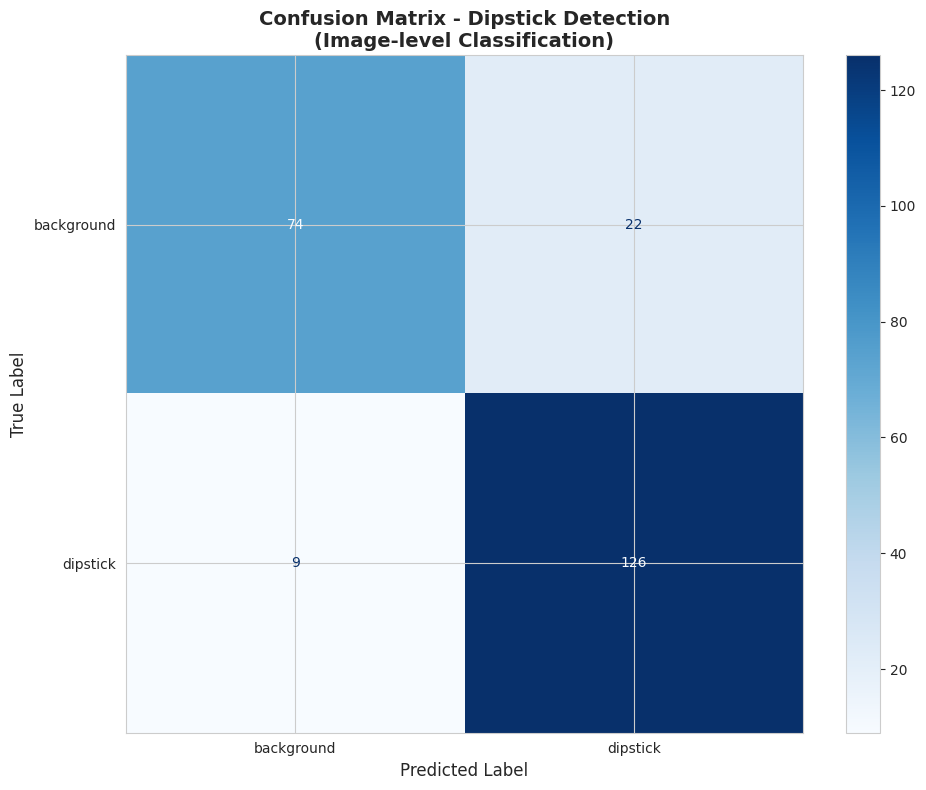

✓ Confusion matrix saved as 'confusion_matrix.png'


In [5]:
# Combine ground truth and predictions
results_df = pd.DataFrame({
    'image': list(ground_truth.keys()),
    'true_label': [ground_truth[img] for img in ground_truth.keys()],
    'predicted_label': [predictions.get(img, 'background') for img in ground_truth.keys()]
})

# Create confusion matrix
y_true = results_df['true_label']
y_pred = results_df['predicted_label']

# Define labels order
labels = ['background', 'dipstick']

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Dipstick Detection\n(Image-level Classification)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved as 'confusion_matrix.png'")

In [6]:
# Classification report
print("="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_true, y_pred, labels=labels, target_names=labels))

# Manual calculation
tn, fp, fn, tp = cm.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print("="*70)
print("DETAILED METRICS")
print("="*70)
print(f"True Positives (TP):  {tp:4d}  - Correctly detected dipstick")
print(f"True Negatives (TN):  {tn:4d}  - Correctly detected background")
print(f"False Positives (FP): {fp:4d}  - Background predicted as dipstick")
print(f"False Negatives (FN): {fn:4d}  - Dipstick predicted as background")
print("="*70)
print(f"Accuracy:    {accuracy:.4f}  ({accuracy*100:.2f}%)")
print(f"Precision:   {precision:.4f}  ({precision*100:.2f}%)")
print(f"Recall:      {recall:.4f}  ({recall*100:.2f}%)")
print(f"F1-Score:    {f1_score:.4f}  ({f1_score*100:.2f}%)")
print(f"Specificity: {specificity:.4f}  ({specificity*100:.2f}%)")
print("="*70)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

  background       0.89      0.77      0.83        96
    dipstick       0.85      0.93      0.89       135

    accuracy                           0.87       231
   macro avg       0.87      0.85      0.86       231
weighted avg       0.87      0.87      0.86       231

DETAILED METRICS
True Positives (TP):   126  - Correctly detected dipstick
True Negatives (TN):    74  - Correctly detected background
False Positives (FP):   22  - Background predicted as dipstick
False Negatives (FN):    9  - Dipstick predicted as background
Accuracy:    0.8658  (86.58%)
Precision:   0.8514  (85.14%)
Recall:      0.9333  (93.33%)
F1-Score:    0.8905  (89.05%)
Specificity: 0.7708  (77.08%)


In [7]:
# Find misclassified images
false_positives = results_df[(results_df['true_label'] == 'background') & 
                              (results_df['predicted_label'] == 'dipstick')]
false_negatives = results_df[(results_df['true_label'] == 'dipstick') & 
                              (results_df['predicted_label'] == 'background')]

print("="*70)
print("ERROR ANALYSIS")
print("="*70)
print(f"\nFalse Positives ({len(false_positives)}): Background diprediksi sebagai Dipstick")
if len(false_positives) > 0:
    print("Sample images:")
    for idx, row in false_positives.head(10).iterrows():
        print(f"  - {row['image']}")

print(f"\nFalse Negatives ({len(false_negatives)}): Dipstick diprediksi sebagai Background")
if len(false_negatives) > 0:
    print("Sample images:")
    for idx, row in false_negatives.head(10).iterrows():
        print(f"  - {row['image']}")

# Save results to CSV
results_df.to_csv('prediction_results.csv', index=False)
false_positives.to_csv('false_positives.csv', index=False)
false_negatives.to_csv('false_negatives.csv', index=False)

print("\n✓ Results saved to CSV files")

ERROR ANALYSIS

False Positives (22): Background diprediksi sebagai Dipstick
Sample images:
  - sch132101971441728275526362.png
  - sch121817151801720067640944.png
  - sch112562318201713322921721.png
  - sch102811251801704349906065.png
  - sch118804530951718002271814.png
  - sch106842716621708061897186.png
  - sch109476771411709610821394.png
  - sch112562527051712212448237.png
  - sch125664830311722820476899.png
  - sch115744154821715154258861.png

False Negatives (9): Dipstick diprediksi sebagai Background
Sample images:
  - sch132088928231727750661295.png
  - sch121809413381720153936915.png
  - sch112565035701712197393934.png
  - sch128377630951725429114403.png
  - sch106859482041707192991688.png
  - sch115746160831717146536787.png
  - sch125666935811722913102255.png
  - sch134890013481730781736173.png
  - sch112573967991711945914756.png

✓ Results saved to CSV files


Visualizing False Positives...


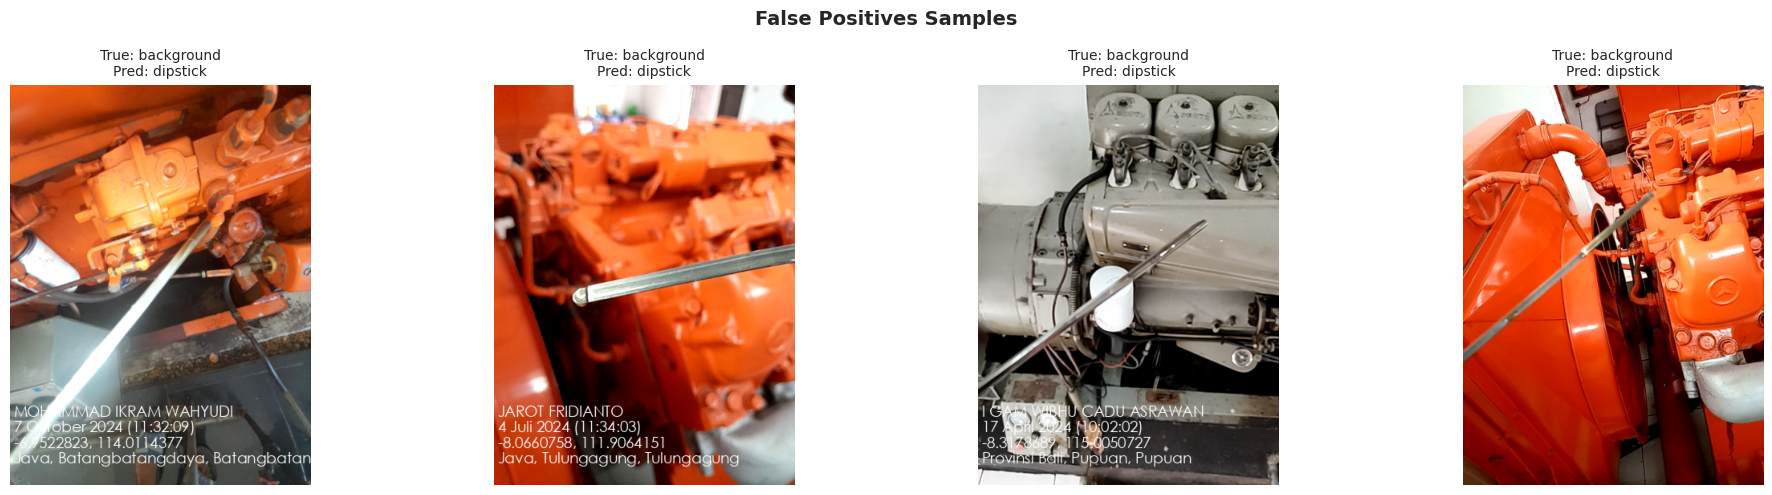


Visualizing False Negatives...


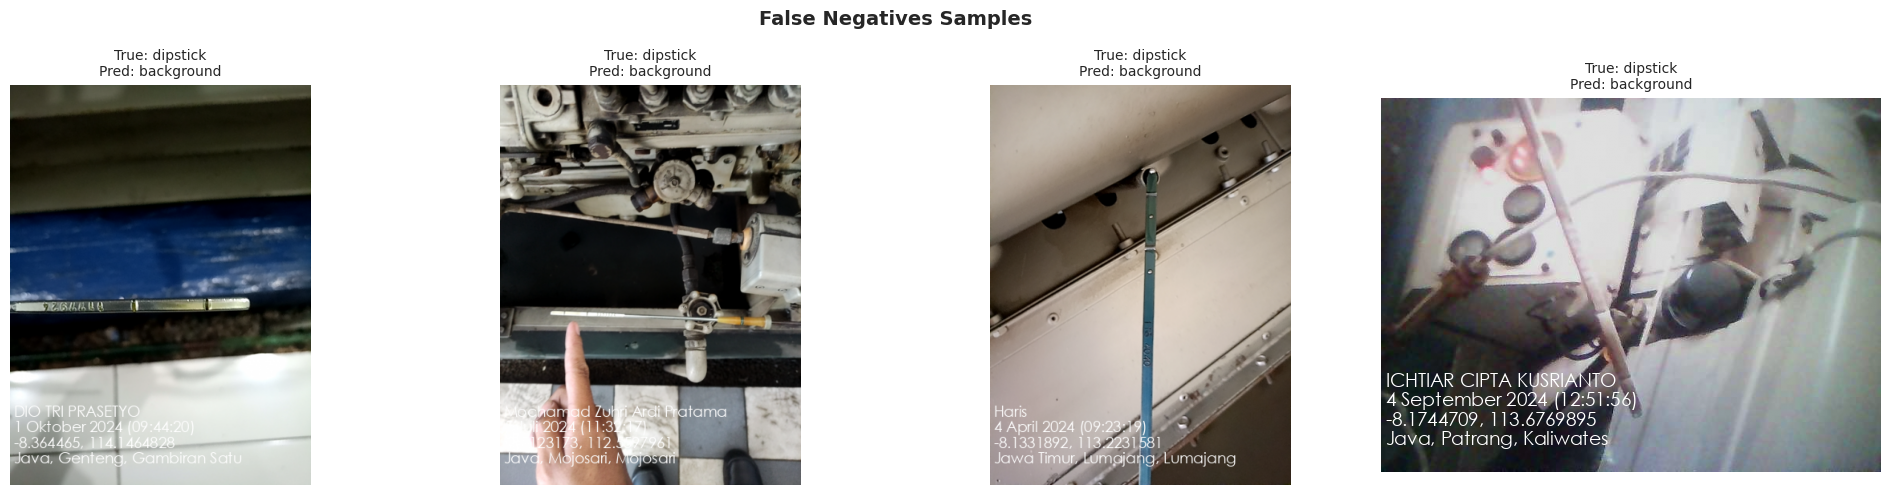


Visualizing True Positives...


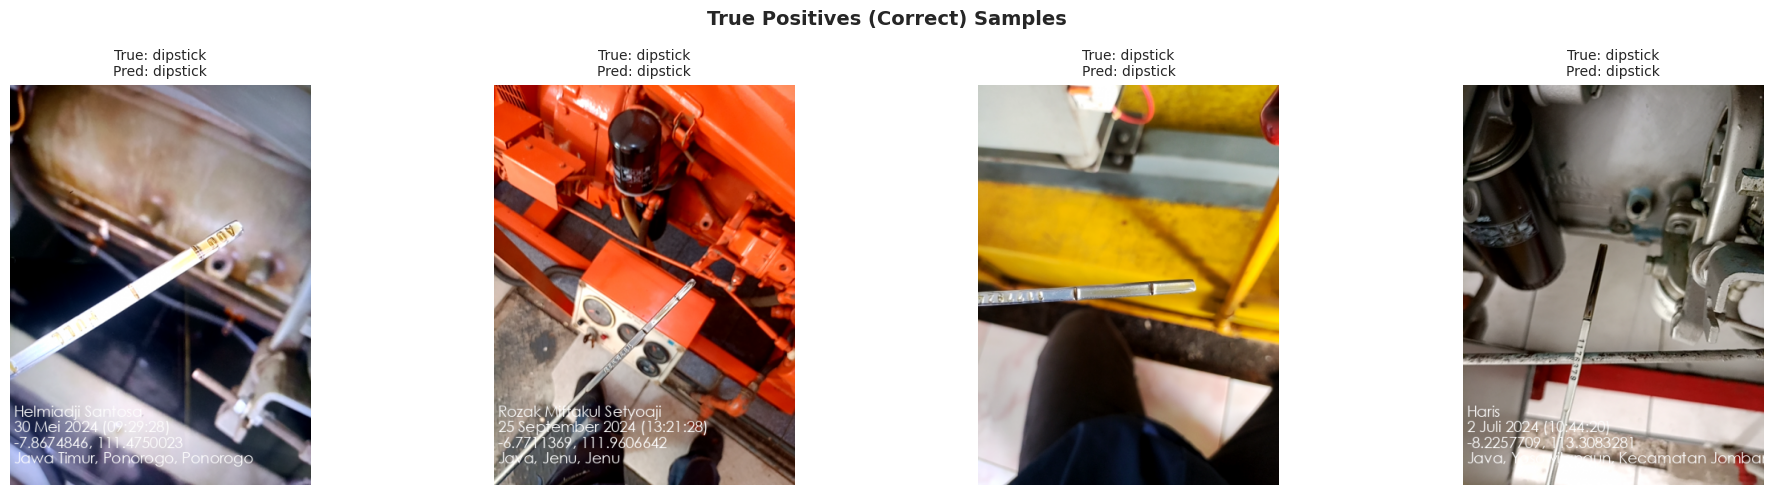


Visualizing True Negatives...


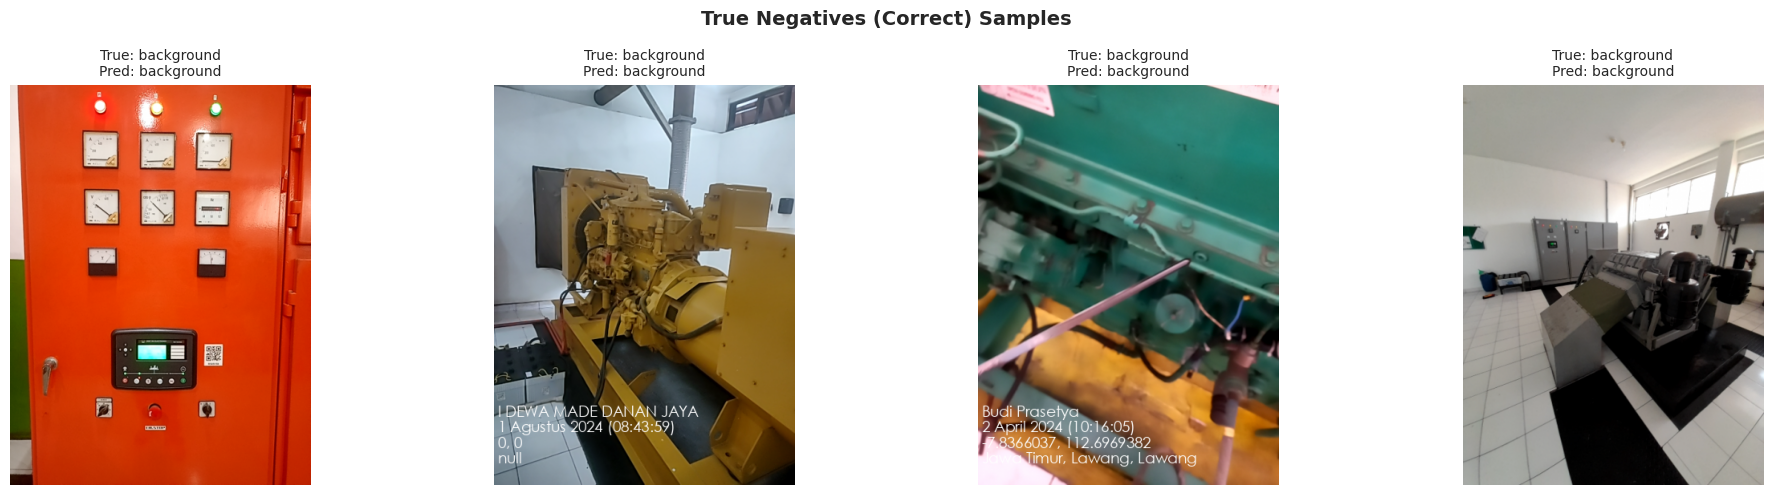

In [8]:
def visualize_samples(df, category, n_samples=4):
    """
    Visualize sample images from a specific category
    """
    if len(df) == 0:
        print(f"No samples found for {category}")
        return
    
    samples = df.head(n_samples)
    n = len(samples)
    
    fig, axes = plt.subplots(1, n, figsize=(5*n, 5))
    if n == 1:
        axes = [axes]
    
    for idx, (_, row) in enumerate(samples.iterrows()):
        img_path = test_images_dir / row['image']
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[idx].imshow(img)
        axes[idx].set_title(f"True: {row['true_label']}\nPred: {row['predicted_label']}", 
                            fontsize=10)
        axes[idx].axis('off')
    
    plt.suptitle(f'{category} Samples', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{category.lower().replace(" ", "_")}_samples.png', dpi=150, bbox_inches='tight')
    plt.show()

# Visualize different categories
print("Visualizing False Positives...")
visualize_samples(false_positives, "False Positives", n_samples=4)

print("\nVisualizing False Negatives...")
visualize_samples(false_negatives, "False Negatives", n_samples=4)

# True Positives
true_positives = results_df[(results_df['true_label'] == 'dipstick') & 
                             (results_df['predicted_label'] == 'dipstick')]
print("\nVisualizing True Positives...")
visualize_samples(true_positives, "True Positives (Correct)", n_samples=4)

# True Negatives
true_negatives = results_df[(results_df['true_label'] == 'background') & 
                             (results_df['predicted_label'] == 'background')]
print("\nVisualizing True Negatives...")
visualize_samples(true_negatives, "True Negatives (Correct)", n_samples=4)

Testing different confidence thresholds...

Testing threshold: 0.1
Running inference on 231 images...


100%|██████████| 231/231 [00:04<00:00, 52.19it/s]


Testing threshold: 0.2
Running inference on 231 images...


100%|██████████| 231/231 [00:04<00:00, 53.27it/s]


Testing threshold: 0.25
Running inference on 231 images...


100%|██████████| 231/231 [00:04<00:00, 52.20it/s]


Testing threshold: 0.3
Running inference on 231 images...


100%|██████████| 231/231 [00:04<00:00, 52.20it/s]


Testing threshold: 0.4
Running inference on 231 images...


100%|██████████| 231/231 [00:04<00:00, 53.08it/s]


Testing threshold: 0.5
Running inference on 231 images...


100%|██████████| 231/231 [00:04<00:00, 54.10it/s]



THRESHOLD COMPARISON
 threshold  accuracy  precision   recall  f1_score  TP  TN  FP  FN
      0.10  0.844156   0.792899 0.992593  0.881579 134  61  35   1
      0.20  0.861472   0.828025 0.962963  0.890411 130  69  27   5
      0.25  0.857143   0.835526 0.940741  0.885017 127  71  25   8
      0.30  0.865801   0.851351 0.933333  0.890459 126  74  22   9
      0.40  0.861472   0.865248 0.903704  0.884058 122  77  19  13
      0.50  0.852814   0.904000 0.837037  0.869231 113  84  12  22


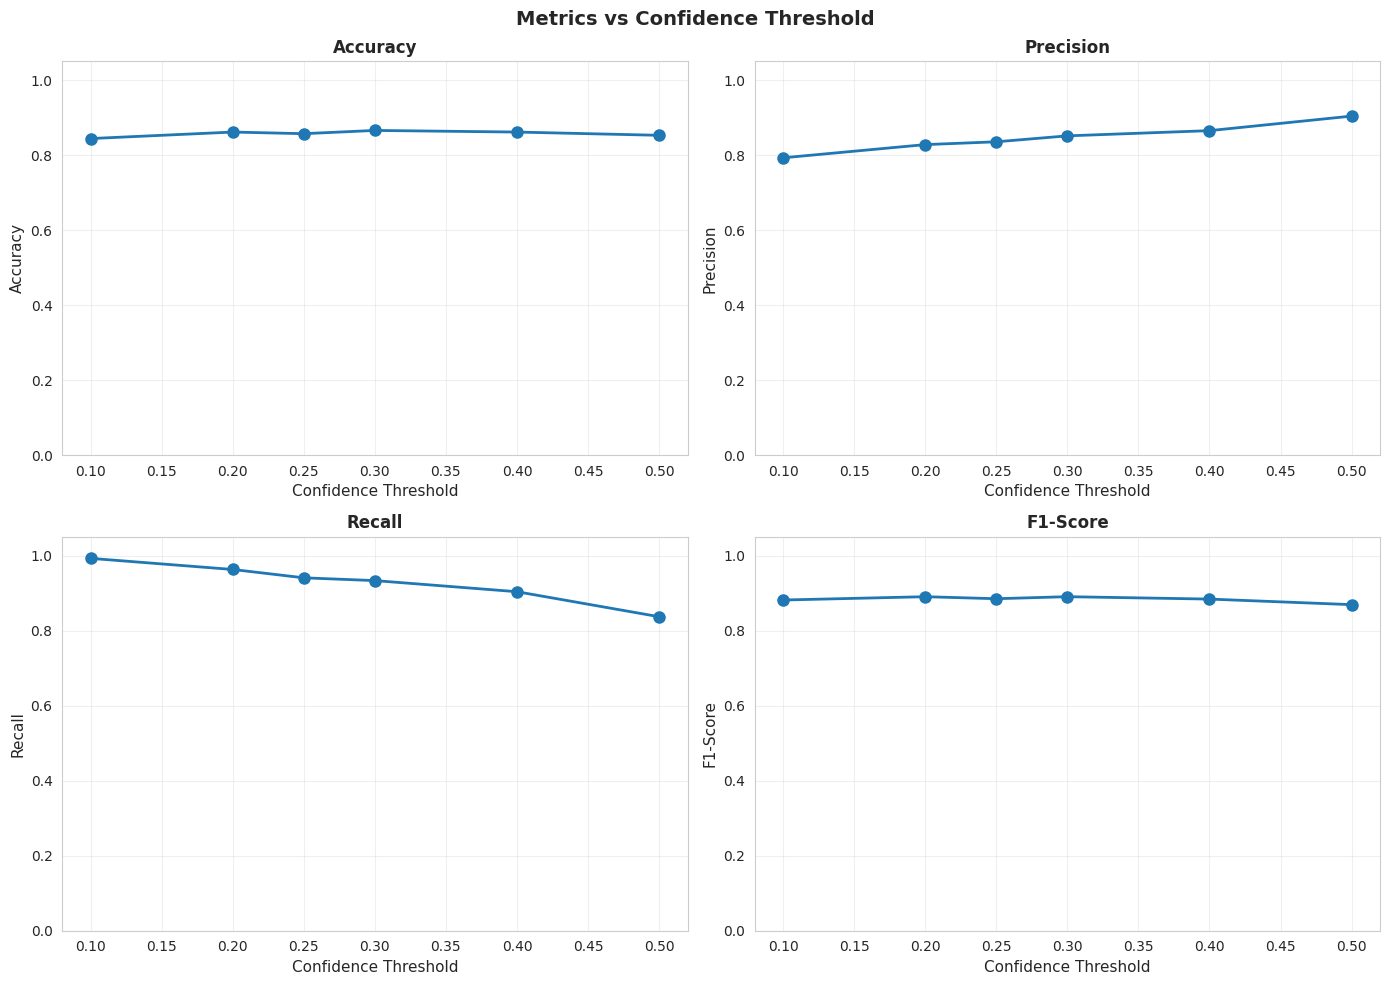


✓ Threshold comparison saved


In [9]:
# Test different thresholds
thresholds = [0.1, 0.2, 0.25, 0.3, 0.4, 0.5]
threshold_results = []

print("Testing different confidence thresholds...\n")

for thresh in thresholds:
    print(f"Testing threshold: {thresh}")
    preds = get_predictions(model, test_images_dir, conf_threshold=thresh)
    
    y_pred_temp = [preds.get(img, 'background') for img in ground_truth.keys()]
    cm_temp = confusion_matrix(y_true, y_pred_temp, labels=labels)
    tn, fp, fn, tp = cm_temp.ravel()
    
    acc = (tp + tn) / (tp + tn + fp + fn)
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0
    
    threshold_results.append({
        'threshold': thresh,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn
    })

# Create comparison dataframe
threshold_df = pd.DataFrame(threshold_results)
print("\n" + "="*70)
print("THRESHOLD COMPARISON")
print("="*70)
print(threshold_df.to_string(index=False))

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['accuracy', 'precision', 'recall', 'f1_score']
titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    row = idx // 2
    col = idx % 2
    axes[row, col].plot(threshold_df['threshold'], threshold_df[metric], 
                        marker='o', linewidth=2, markersize=8)
    axes[row, col].set_xlabel('Confidence Threshold', fontsize=11)
    axes[row, col].set_ylabel(title, fontsize=11)
    axes[row, col].set_title(title, fontsize=12, fontweight='bold')
    axes[row, col].grid(True, alpha=0.3)
    axes[row, col].set_ylim([0, 1.05])

plt.suptitle('Metrics vs Confidence Threshold', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('threshold_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Save to CSV
threshold_df.to_csv('threshold_comparison.csv', index=False)
print("\n✓ Threshold comparison saved")